## Obtaining the Efficient Frontier -

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as wb
%matplotlib inline

assets = ['NKE','GOOGL','AMZN']
pf_data = pd.DataFrame()

for a in assets:
    pf_data[a] = wb.DataReader(a, start = '2015-1-1')['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Do a quick check of the data, normalize it to 100, and see how the 3 stocks were doing during the given timeframe. 

In [3]:
pf_data.tail()

,NKE,GOOGL,AMZN
Date,,,
2024-04-19,94.529999,154.089996,174.630005
2024-04-22,94.190002,156.279999,177.229996
2024-04-23,94.019997,158.259995,179.539993
2024-04-24,94.639999,159.130005,176.589996
2024-04-25,93.940002,156.000000,173.669998


<Axes: xlabel='Date'>

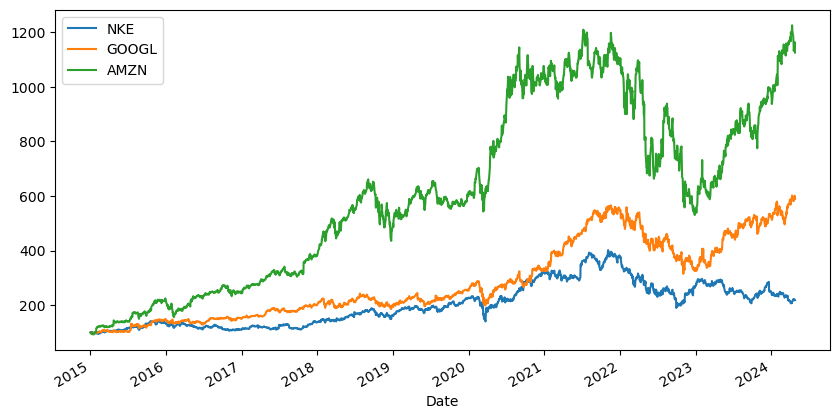

In [4]:
(pf_data / pf_data.iloc[0] * 100).plot(figsize=(10, 5))

Returns: It refers to the gain or loss on our asset/portfolio over a fixed time frame. In this analysis, we make a return as the percentage change in the closing price of the asset over the previous day’s closing price. We will compute the returns using .pct_change() function in python.

Below is shown the python code to do the same and the top 5 rows (head) of the returns

Note: the first row is Null if there doesn’t exist a row prior to that to facilitate the computation of percentage change.

In [5]:
returns_portfolio = pf_data.pct_change()
returns_portfolio.head

<bound method NDFrame.head of                  NKE     GOOGL      AMZN
Date                                    
2015-01-02       NaN       NaN       NaN
2015-01-05 -0.016100 -0.019054 -0.020517
2015-01-06 -0.005883 -0.024679 -0.022833
2015-01-07  0.020656 -0.002941  0.010600
2015-01-08  0.023084  0.003484  0.006836
...              ...       ...       ...
2024-04-19 -0.012638 -0.012307 -0.025611
2024-04-22 -0.003597  0.014212  0.014889
2024-04-23 -0.001805  0.012670  0.013034
2024-04-24  0.006594  0.005497 -0.016431
2024-04-25 -0.007396 -0.019669 -0.016535

[2344 rows x 3 columns]>

Return of a portfolio is defined as the weighted sum of the returns of the assets in the portfolio.

In order to demonstrate how to compute portfolio return in python, let us initialize the weights randomly (which we will later optimize). The portfolio return is computed as shown in the code below and the head of the portfolio returns is shown as well:

In [8]:
weight_portfolio = [0.4,0.3,0.3]
portfolio_return = returns_portfolio.dot(weight_portfolio)
portfolio_return.head

<bound method NDFrame.head of Date
2015-01-02         NaN
2015-01-05   -0.018311
2015-01-06   -0.016607
2015-01-07    0.010560
2015-01-08    0.012330
                ...   
2024-04-19   -0.016431
2024-04-22    0.007292
2024-04-23    0.006989
2024-04-24   -0.000642
2024-04-25   -0.013820
Length: 2344, dtype: float64>

We have seen how to calculate the returns, now lets shift our focus on another concept : Risk

# The Risk Associated with Asset & Portfolio

In [9]:
variance_matrix = returns_portfolio.cov()*252
variance_matrix

,NKE,GOOGL,AMZN
NKE,0.085830,0.037647,0.037986
GOOGL,0.037647,0.081028,0.061114
AMZN,0.037986,0.061114,0.109135


In [10]:
#computing portfolio variance
portfolio_variance = np.transpose(weight_portfolio)@variance_matrix@weight_portfolio

In [11]:
#computing portfolio volatility (risk)
portfolio_volatility = np.sqrt(portfolio_variance)


In [12]:
print("portfolio variance is",portfolio_variance)

portfolio variance is 0.05999985721801872


In [13]:
print("portfolio Volatility(risk) is",portfolio_volatility)

portfolio Volatility(risk) is 0.24494868282564558


Now, the task for us is to optimize the weights. Why? So that we can maximize our return or minimize our risk – and that we do by using the Modern Portfolio Theory!
Firstly, we create the efficient frontier by running a loop. In each loop, we consider a randomly allocated different set of weights for the assets in our portfolio and calculate the return and volatility for that combination of weights.

For this purpose we create 3 empty lists , one for storing the returns , another for storing the volatility and the last one for storing the portfolio weights.

In [14]:
#initialize an empty list for storing the portfolio return
port_returns = []

In [15]:
#initialize an empty list for storing the portfolio volatility
port_volatility = []

In [16]:
#initialize an empty list for storing the portfolio weight
port_weights = []

In [17]:
num_assets = len(pf_data.columns)


In [18]:
num_portfolios = 10000
individual_rets = pf_data.resample('Y').last().pct_change().mean()


Once we have created the lists, we randomly generate the weights for our assets repeatedly , then normalized the weight to sum to 1. We then compute the returns in the same manner as we calculated earlier. Subsequently, we compute the portfolio variance and then we take the square root and then annualize it to get the volatility, the measure of risk for our portfolio.

In [19]:
for port in range(num_portfolios):
    #randomly generate weight combination
    weights = np.random.random(num_assets)
    #normalize weight so that they sum to 1
    weights = weights/np.sum(weights)
    port_weights.append(weights)
    #returns are the dot products od individual expected returns of assets and its weight
    returns = np.dot(weights,individual_rets)
    port_returns.append(returns)
    
    #computing portfolio varinace 
    var = variance_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    #Daily standard deviation :volatility is square root of variance
    sd = np.sqrt(var)
    #Annualise the stadard deviation will give us the volatility 
    ann_sd = sd*np.sqrt(252)
    port_volatility.append(ann_sd)
    

We now aggregate the data into a dictionary and then create a dataframe to see the weight combination for the assets and the corresponding returns and volatility that they generate.

In [20]:
#Creating dictionary of returns and volatility 
data = {'Returns':port_returns, 'Volatility':port_volatility}

for counter, symbol in enumerate(pf_data.columns.tolist()):
    data[symbol+'weight'] = [w[counter] for w in port_weights]
    portfolios_V1  = pd.DataFrame(data)
    portfolios_V1.head()
    

Now we have everything with us to enter into the final lap of this race and find the optimal set of weights!

We plot Volatility against the returns that we compute above, this will give us the Efficient Frontier that we wanted to create at the beginning of this work.

Text(0, 0.5, 'Expected Returns')

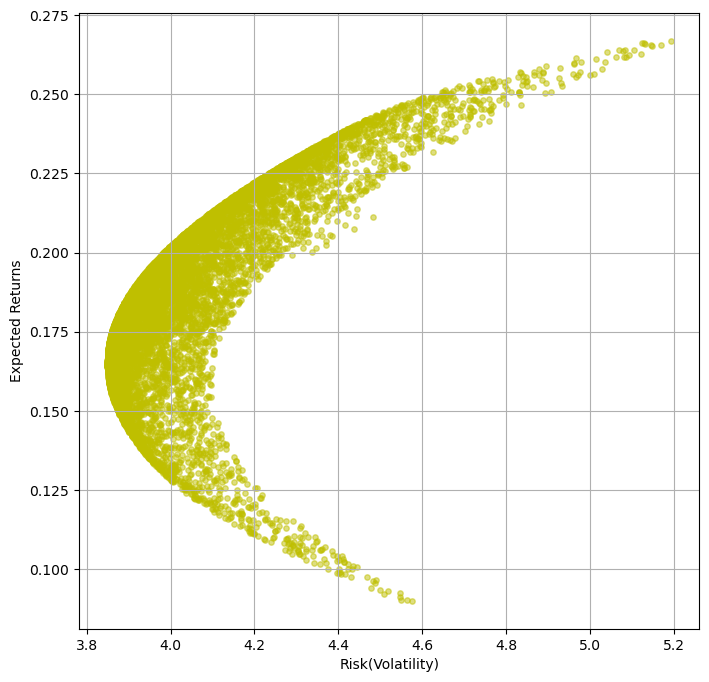

In [21]:
#plot efficient frontier
portfolios_V1.plot.scatter(x='Volatility', y='Returns',marker='o',color='y',
                           s=15, alpha=0.5, grid=True, figsize=[8,8])
plt.xlabel("Risk(Volatility)")
plt.ylabel("Expected Returns")

# Now that we have with us the Efficient Frontier, let’s find the optimal weights.

We can optimize the using multiple methods as written below:

1.Portfolio with minimum Volatility (Risk)
2.Optimal Portfolio (Maximum Sharpe Ratio)



To find the minimum volatility combination, we select the row in our dataframe which corresponds to the minimum variance and we find that row using the .idxmin() function. The code to do the same is shown below:

In [22]:
#MIN VOLATILITY
# idxmin() gives us the minimum value in the column that has been specified
min_vol_port = portfolios_V1.iloc[portfolios_V1['Volatility'].idxmin()]
min_vol_port

Returns        0.164724
Volatility     3.849279
NKEweight      0.438933
GOOGLweight    0.400846
AMZNweight     0.160222
Name: 5761, dtype: float64

The Sharpe-ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. The formula used to calculate Sharpe-ratio is given below:

                                                            Sharpe Ratio = (Rp – Rf)/ SDp

where,

Rp is the return of portfolio,
Rf is the risk free rate,
SDp is the standard deviation of the portfolio’s returns

In [23]:
#Finding the optimal portfolio: Highest SHARPE Ratio
#risk factor
rf = 0.01
optimal_risk_port = portfolios_V1.iloc[((portfolios_V1['Returns']-rf)/portfolios_V1['Volatility']).
                                      idxmax()]
optimal_risk_port

Returns        0.245042
Volatility     4.521012
NKEweight      0.002114
GOOGLweight    0.406308
AMZNweight     0.591578
Name: 5965, dtype: float64

Text(0, 0.5, 'Expected Return')

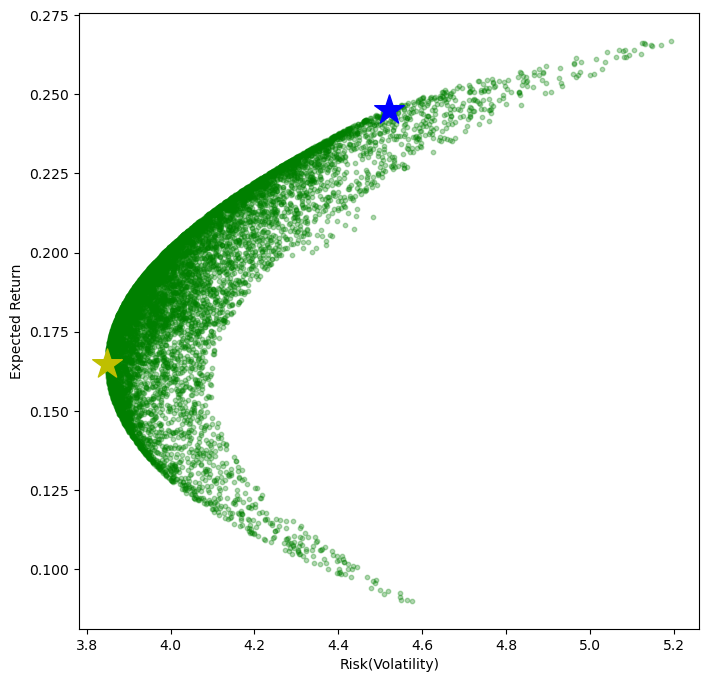

In [24]:
#plotting optimal portfolio and minimum volatility 
plt.subplots(figsize=(8, 8))
plt.scatter(portfolios_V1['Volatility'], portfolios_V1['Returns'],marker='o', s=10,
           alpha=0.3, color ='green')
plt.scatter(min_vol_port[1], min_vol_port[0], color='y', marker='*', s=500)
plt.scatter(optimal_risk_port[1], optimal_risk_port[0], color='b', marker='*', s=500)
plt.xlabel("Risk(Volatility)")
plt.ylabel("Expected Return")


The blue star corresponds to the highest Sharpe ratio point and the yellow star corresponds to the minimum volatility point.